In [220]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import os
import requests
import json
import time
import unicodedata
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from dotenv import load_dotenv
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
import alpaca_trade_api as tradeapi
import datetime
from dateutil.relativedelta import relativedelta

import sklearn
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from pandas_datareader import data as pdr
import yfinance
from pathlib import Path
import hvplot.pandas

## Initializations

In [221]:
file_path = './Resources/NVDA_from_2015.csv'
data = pd.read_csv(file_path, index_col='timestamp', parse_dates=True, infer_datetime_format=True)
data

,Open,High,Low,Close,Volume,trade_count,vwap
timestamp,,,,,,,
2015-12-01 05:00:00+00:00,32.00,32.78,31.9700,32.75,10237433,57496,32.548577
2015-12-02 05:00:00+00:00,32.80,33.14,32.4300,32.50,7356004,45711,32.752748
2015-12-03 05:00:00+00:00,32.81,33.10,32.2700,32.43,6166405,39926,32.586531
2015-12-04 05:00:00+00:00,32.43,33.81,32.4300,33.75,11468924,62693,33.485211
2015-12-07 05:00:00+00:00,33.74,33.74,33.0100,33.11,8339679,51065,33.218717
...,...,...,...,...,...,...,...
2022-09-26 04:00:00+00:00,124.99,126.59,122.1400,122.28,54734269,454184,123.856596
2022-09-27 04:00:00+00:00,125.07,127.36,122.5800,124.13,55385401,452229,124.844863
2022-09-28 04:00:00+00:00,124.04,128.23,123.5386,127.36,54232724,437387,126.295740


In [222]:
# Load the environment variables from the .env file
#by calling the load_dotenv function
load_dotenv()

True

In [223]:
# Set api keys and base url
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [224]:
# Create the Alpaca tradeapi.REST object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [225]:
# Set start and end dates
today = datetime.datetime.today().date()
back = today - relativedelta(years=10)
print(today,back)

start_date = pd.Timestamp(back, tz="America/New_York").isoformat()
end_date = pd.Timestamp(today, tz="America/New_York").isoformat()
print(start_date, end_date)

2022-09-30 2012-09-30
2012-09-30T00:00:00-04:00 2022-09-30T00:00:00-04:00


In [226]:
# closing_prices_df = alpaca.get_bars("AAPL", TimeFrame.Day, start_date, end_date, adjustment='raw').df



In [227]:
# data = closing_prices_df.rename({'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'volume':'Volume'}, axis=1)
# data


In [228]:
# data.to_csv(filepath)

## Use Technical Indicators to generate features

### CCI

In [229]:
days = 20
TP = (data['High'] + data['Low'] + data['Close']) / 3

In [230]:
CCI = pd.Series((TP - TP.rolling(window=days).mean()) / (0.015 * TP.rolling(window=days).std()), name = 'CCI')
data = pd.concat([data, CCI], axis=1)


### EVM

In [231]:
days = 14
dm = ((data['High'] + data['Low'])/2) - ((data['High'].shift(1) + data['Low'].shift(1))/2)
br = (data['Volume'] / 100000000) / ((data['High'] - data['Low']))
EVM = dm / br 


In [232]:
EVM_MA = pd.Series(EVM.rolling(window=days).mean(), name = 'EVM')
data = pd.concat([data, EVM_MA], axis=1)


### SMA & EWMA

In [233]:
def SMA(data, days): 
    close = data['Close']
    # sma = pd.Series(pd.rolling_mean(data['Close'], days), name = 'SMA_' + str(days))
    sma = pd.Series(close.rolling(window=days).mean(), name = ('SMA_' + str(days)))
    data = pd.concat([data, sma], axis=1)
    return data

In [234]:
def EWMA(data, days):
    close = data['Close']
    # ema = pd.Series(pd.ewma(data['Close'], span = days, min_periods = days - 1), name = 'EWMA_' + str(days))
    ema = pd.Series(close.ewm(span = days, min_periods = (days - 1)).mean(), name = 'EWMA_' + str(days))
    data = pd.concat([data, ema], axis=1)
    return data

In [235]:
# Calculate SMAs

days_list = [4,20,100,200]
for days in days_list:
    data = SMA(data, days)
    data = EWMA(data, days)


### ROC

In [236]:
N = data['Close'].diff(days)
D = data['Close'].shift(days)
roc = pd.Series(N/D,name='ROC')
data = pd.concat([data, roc], axis=1)


### Bolinger Bands

In [237]:
MA = data.Close.rolling(window=days).mean()
SD = data.Close.rolling(window=days).std()
data['UpperBB'] = MA + (2 * SD) 
data['LowerBB'] = MA - (2 * SD)


### Force Index

In [238]:
FI = pd.Series(data['Close'].diff(days) * data['Volume'], name = 'ForceIndex') 
data = data = pd.concat([data, FI], axis=1)


In [239]:
data = data.dropna().astype('float')
data

,Open,High,Low,Close,Volume,trade_count,vwap,CCI,EVM,SMA_4,...,SMA_20,EWMA_20,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-09-16 04:00:00+00:00,62.91,63.25,62.1200,62.84,22561149.0,81952.0,62.815168,62.613102,-0.550104,61.4500,...,61.8925,61.310096,51.127900,52.888891,41.591650,47.829485,0.918779,64.749520,18.433780,6.788650e+08
2016-09-19 04:00:00+00:00,63.50,65.26,63.2100,63.67,10428207.0,64792.0,64.128246,129.803829,1.346208,62.4000,...,61.9630,61.534849,51.391500,53.106202,41.747500,48.011209,0.959077,65.078293,18.416707,3.250472e+08
2016-09-20 04:00:00+00:00,63.87,64.40,62.7400,63.09,8277832.0,46730.0,63.289752,84.195839,0.693513,63.0725,...,61.9915,61.682958,51.660400,53.307370,41.900800,48.183930,0.945421,65.387864,18.413736,2.537983e+08
2016-09-21 04:00:00+00:00,63.28,64.98,63.2700,64.86,8405337.0,57113.0,64.231303,124.725059,1.686412,63.6150,...,62.0890,61.985534,51.953700,53.540069,42.056350,48.374662,0.921778,65.737672,18.375028,2.614900e+08
2016-09-22 04:00:00+00:00,65.24,65.44,64.6500,65.02,7718287.0,56690.0,64.969322,134.558741,1.243620,64.1600,...,62.2430,62.274531,52.243900,53.771225,42.215900,48.564759,0.963757,66.084152,18.347648,2.462905e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26 04:00:00+00:00,124.99,126.59,122.1400,122.28,54734269.0,454184.0,123.856596,-91.663909,-7.912012,126.4150,...,136.7590,138.546698,165.409101,171.143821,207.865151,210.101850,-0.615786,307.569875,108.160427,-1.072682e+10
2022-09-27 04:00:00+00:00,125.07,127.36,122.5800,124.13,55385401.0,452229.0,124.844863,-83.032771,-7.723688,124.2950,...,135.0650,137.173679,164.617001,170.212854,206.961301,209.246408,-0.592883,306.406876,107.515726,-1.001202e+10
2022-09-28 04:00:00+00:00,124.04,128.23,123.5386,127.36,54232724.0,437387.0,126.295740,-68.471628,-7.863974,124.7325,...,133.6990,136.239043,164.006201,169.364283,206.088201,208.431618,-0.578250,305.245871,106.930531,-9.470118e+09


In [240]:
# Create a column to hold the trading signal
data['Signal'] = 0.0

In [241]:
# Generate the trading signal 0 or 1,
# where 1 is the short-window greater than the long-window
# and 0 is when the condition is not met
short_window = 4
long_window = 20
data['Signal'][short_window:] = np.where(
    data['SMA_4'][short_window:] > data['SMA_20'][short_window:], 1.0, 0.0
)

data.tail(10)

,Open,High,Low,Close,Volume,trade_count,vwap,CCI,EVM,SMA_4,...,EWMA_20,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex,Signal
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-09-19 04:00:00+00:00,130.13,134.6300,130.1000,133.82,57068523.0,443333.0,132.933449,-61.375148,-22.693011,131.5925,...,146.073194,168.622801,175.746838,212.533501,214.340502,-0.574296,314.256144,110.810858,-1.030258e+10,0.0
2022-09-20 04:00:00+00:00,131.99,134.8276,130.5700,131.76,52481775.0,419546.0,132.661030,-57.600614,-17.395642,131.7125,...,144.710033,168.098901,174.875811,211.586001,213.518806,-0.589865,312.766102,110.405900,-9.945296e+09,0.0
2022-09-21 04:00:00+00:00,132.11,140.3100,131.1000,132.61,80771502.0,632676.0,134.857729,-42.900227,-12.331708,132.5425,...,143.557649,167.446801,174.038864,210.714401,212.713743,-0.567947,311.595552,109.833250,-1.408009e+10,0.0
2022-09-22 04:00:00+00:00,130.79,131.4897,124.2800,125.61,75895399.0,659242.0,126.749126,-72.603118,-8.070396,130.9500,...,141.848349,166.848201,173.079877,209.840601,211.847039,-0.581816,310.627257,109.053945,-1.326348e+10,0.0
2022-09-23 04:00:00+00:00,124.31,126.1100,122.5700,125.16,66496787.0,565375.0,124.074456,-85.476067,-9.729296,128.7850,...,140.258982,166.146501,172.130969,208.845051,210.984481,-0.614025,309.019422,108.670680,-1.324018e+10,0.0
2022-09-26 04:00:00+00:00,124.99,126.5900,122.1400,122.28,54734269.0,454184.0,123.856596,-91.663909,-7.912012,126.4150,...,138.546698,165.409101,171.143821,207.865151,210.101850,-0.615786,307.569875,108.160427,-1.072682e+10,0.0
2022-09-27 04:00:00+00:00,125.07,127.3600,122.5800,124.13,55385401.0,452229.0,124.844863,-83.032771,-7.723688,124.2950,...,137.173679,164.617001,170.212854,206.961301,209.246408,-0.592883,306.406876,107.515726,-1.001202e+10,0.0
2022-09-28 04:00:00+00:00,124.04,128.2300,123.5386,127.36,54232724.0,437387.0,126.295740,-68.471628,-7.863974,124.7325,...,136.239043,164.006201,169.364283,206.088201,208.431618,-0.578250,305.245871,106.930531,-9.470118e+09,0.0
2022-09-29 04:00:00+00:00,124.32,125.0000,119.4601,122.20,53302711.0,485218.0,121.684278,-106.387017,-13.697162,123.9925,...,134.901992,163.360701,168.430336,205.291151,207.573592,-0.566067,304.571046,106.011256,-8.496985e+09,0.0


In [242]:
# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
data['Entry/Exit'] = data['Signal'].diff()
data

,Open,High,Low,Close,Volume,trade_count,vwap,CCI,EVM,SMA_4,...,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex,Signal,Entry/Exit
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-09-16 04:00:00+00:00,62.91,63.25,62.1200,62.84,22561149.0,81952.0,62.815168,62.613102,-0.550104,61.4500,...,51.127900,52.888891,41.591650,47.829485,0.918779,64.749520,18.433780,6.788650e+08,0.0,NaN
2016-09-19 04:00:00+00:00,63.50,65.26,63.2100,63.67,10428207.0,64792.0,64.128246,129.803829,1.346208,62.4000,...,51.391500,53.106202,41.747500,48.011209,0.959077,65.078293,18.416707,3.250472e+08,0.0,0.0
2016-09-20 04:00:00+00:00,63.87,64.40,62.7400,63.09,8277832.0,46730.0,63.289752,84.195839,0.693513,63.0725,...,51.660400,53.307370,41.900800,48.183930,0.945421,65.387864,18.413736,2.537983e+08,0.0,0.0
2016-09-21 04:00:00+00:00,63.28,64.98,63.2700,64.86,8405337.0,57113.0,64.231303,124.725059,1.686412,63.6150,...,51.953700,53.540069,42.056350,48.374662,0.921778,65.737672,18.375028,2.614900e+08,0.0,0.0
2016-09-22 04:00:00+00:00,65.24,65.44,64.6500,65.02,7718287.0,56690.0,64.969322,134.558741,1.243620,64.1600,...,52.243900,53.771225,42.215900,48.564759,0.963757,66.084152,18.347648,2.462905e+08,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26 04:00:00+00:00,124.99,126.59,122.1400,122.28,54734269.0,454184.0,123.856596,-91.663909,-7.912012,126.4150,...,165.409101,171.143821,207.865151,210.101850,-0.615786,307.569875,108.160427,-1.072682e+10,0.0,0.0
2022-09-27 04:00:00+00:00,125.07,127.36,122.5800,124.13,55385401.0,452229.0,124.844863,-83.032771,-7.723688,124.2950,...,164.617001,170.212854,206.961301,209.246408,-0.592883,306.406876,107.515726,-1.001202e+10,0.0,0.0
2022-09-28 04:00:00+00:00,124.04,128.23,123.5386,127.36,54232724.0,437387.0,126.295740,-68.471628,-7.863974,124.7325,...,164.006201,169.364283,206.088201,208.431618,-0.578250,305.245871,106.930531,-9.470118e+09,0.0,0.0


In [243]:
data['Entry/Exit'].value_counts()

 0.0    1424
 1.0      48
-1.0      48
Name: Entry/Exit, dtype: int64

In [244]:
# Visualize exit position relative to close price
# from configparser import LegacyInterpolation

### Split Dataset to train and test

In [245]:
# Visualize entry position relative to close price
entry = data[data['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

#Show the plot
entry


:Scatter   [timestamp]   (Close)

In [246]:
# Visualize exit position relative to close price
exit = data[data['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='yellow',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

#Show the plot
exit

:Scatter   [timestamp]   (Close)

In [247]:
# Visualize close price for the investment
security_close = data[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

#Show the plot
security_close



:Curve   [timestamp]   (Close)

In [248]:
# Visualize moving averages
moving_avgs = data[['SMA_4', 'SMA_20']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Show the plot
moving_avgs

:NdOverlay   [Variable]
   :Curve   [timestamp]   (value)

In [249]:
# Create the overlay plot
entry_exit_plot = moving_avgs * security_close * entry * exit

# Show the plot
entry_exit_plot.opts(
    title='NVDA - SMA_short, SMA_long, Entry and Exit Points'
)

:Overlay
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [timestamp]   (value)
   .Curve.I          :Curve   [timestamp]   (Close)
   .Scatter.Close.I  :Scatter   [timestamp]   (Close)
   .Scatter.Close.II :Scatter   [timestamp]   (Close)

## Execute trades based on the entry/exit signals and calculate P&L

In [250]:
# Add the trade_type column to track buys and sells
data['trade_type'] = np.nan

In [251]:
# Initialize a cost/proceeds column for recording trade metrics
data["cost/proceeds"] = np.nan

In [252]:
# Initialize share size and accumulated shares
share_size = 100
accumulated_shares = 0
bought = False
initial_investment = 0

In [253]:
# Loop through the Pandas DataFrame and initiate a trade at each iteration
for index, row in data.iterrows():

    # buy if the previous_price is 0, in other words, buy on the first day
    if row["Entry/Exit"] == 1:
        data.loc[index, "trade_type"] = "buy"

        bought = True  # indicate stock has been bought

        if initial_investment == 0:
            initial_investment = row["Close"] * share_size

        # calculate the cost of the trade by multiplying the current day's price
        # by the share_size, or number of shares purchased
        data.loc[index, "cost/proceeds"] = -(row["Close"] * share_size)

        # add the number of shares purchased to the accumulated shares
        accumulated_shares += share_size

    # buy if the current day's price is less than the previous day's price
    elif row["Entry/Exit"] == -1 and bought: #able to sell only when stock has first been bought
        data.loc[index, "trade_type"] = "sell"

        # calculate the cost of the trade by multiplying the current day's price
        # by the share_size, or number of shares purchased
        data.loc[index, "cost/proceeds"] = (row["Close"] * share_size)

        # add the number of shares purchased to the accumulated shares
        accumulated_shares -= share_size

    # hold if the current day's price is equal to the previous day's price
    else:
        data.loc[index, "trade_type"] = "hold"

    # if the index is the last index of the DataFrame and there is still accumulated stock, sell the remaining holding
    if index == data.index[-1] and accumulated_shares !=0:
        data.loc[index, "trade_type"] = "sell"

        # calculate the proceeds by multiplying the last day's price by the accumulated shares
        data.loc[index, "cost/proceeds"] = row["Close"] * accumulated_shares

        accumulated_shares = 0

In [254]:
data

,Open,High,Low,Close,Volume,trade_count,vwap,CCI,EVM,SMA_4,...,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex,Signal,Entry/Exit,trade_type,cost/proceeds
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-09-16 04:00:00+00:00,62.91,63.25,62.1200,62.84,22561149.0,81952.0,62.815168,62.613102,-0.550104,61.4500,...,41.591650,47.829485,0.918779,64.749520,18.433780,6.788650e+08,0.0,NaN,hold,NaN
2016-09-19 04:00:00+00:00,63.50,65.26,63.2100,63.67,10428207.0,64792.0,64.128246,129.803829,1.346208,62.4000,...,41.747500,48.011209,0.959077,65.078293,18.416707,3.250472e+08,0.0,0.0,hold,NaN
2016-09-20 04:00:00+00:00,63.87,64.40,62.7400,63.09,8277832.0,46730.0,63.289752,84.195839,0.693513,63.0725,...,41.900800,48.183930,0.945421,65.387864,18.413736,2.537983e+08,0.0,0.0,hold,NaN
2016-09-21 04:00:00+00:00,63.28,64.98,63.2700,64.86,8405337.0,57113.0,64.231303,124.725059,1.686412,63.6150,...,42.056350,48.374662,0.921778,65.737672,18.375028,2.614900e+08,0.0,0.0,hold,NaN
2016-09-22 04:00:00+00:00,65.24,65.44,64.6500,65.02,7718287.0,56690.0,64.969322,134.558741,1.243620,64.1600,...,42.215900,48.564759,0.963757,66.084152,18.347648,2.462905e+08,1.0,1.0,buy,-6502.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26 04:00:00+00:00,124.99,126.59,122.1400,122.28,54734269.0,454184.0,123.856596,-91.663909,-7.912012,126.4150,...,207.865151,210.101850,-0.615786,307.569875,108.160427,-1.072682e+10,0.0,0.0,hold,NaN
2022-09-27 04:00:00+00:00,125.07,127.36,122.5800,124.13,55385401.0,452229.0,124.844863,-83.032771,-7.723688,124.2950,...,206.961301,209.246408,-0.592883,306.406876,107.515726,-1.001202e+10,0.0,0.0,hold,NaN
2022-09-28 04:00:00+00:00,124.04,128.23,123.5386,127.36,54232724.0,437387.0,126.295740,-68.471628,-7.863974,124.7325,...,206.088201,208.431618,-0.578250,305.245871,106.930531,-9.470118e+09,0.0,0.0,hold,NaN


In [255]:
print("accumulated_shares =", accumulated_shares)

accumulated_shares = 0


In [256]:
print (f"The investment made is ${initial_investment:,.2f}" )

The investment made is $6,502.00


In [257]:
# Calculate the total profit/loss for 100 share size orders
total_profit_loss = data["cost/proceeds"].sum()

# Print the profit/loss metrics
print(f"The total profit/loss of the trading strategy is ${total_profit_loss:,.2f}")

The total profit/loss of the trading strategy is $40,733.51


In [258]:
# Calculate the return on investment (ROI)
roi = (total_profit_loss / initial_investment) * 100

# Print the ROI
print(f"The trading algorithm resulted in a return on investment of {roi:,.2f}%")

The trading algorithm resulted in a return on investment of 626.48%


In [259]:
filepath = Path('data.csv')   
data.to_csv(filepath)

## Machine Learning

In [260]:
data_ml = data.shift().drop(columns=['Entry/Exit', 'trade_type', 'cost/proceeds']).dropna()
X = data_ml.drop(columns=['Signal'])
X

,Open,High,Low,Close,Volume,trade_count,vwap,CCI,EVM,SMA_4,...,SMA_20,EWMA_20,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-09-19 04:00:00+00:00,62.91,63.25,62.1200,62.84,22561149.0,81952.0,62.815168,62.613102,-0.550104,61.4500,...,61.8925,61.310096,51.127900,52.888891,41.591650,47.829485,0.918779,64.749520,18.433780,6.788650e+08
2016-09-20 04:00:00+00:00,63.50,65.26,63.2100,63.67,10428207.0,64792.0,64.128246,129.803829,1.346208,62.4000,...,61.9630,61.534849,51.391500,53.106202,41.747500,48.011209,0.959077,65.078293,18.416707,3.250472e+08
2016-09-21 04:00:00+00:00,63.87,64.40,62.7400,63.09,8277832.0,46730.0,63.289752,84.195839,0.693513,63.0725,...,61.9915,61.682958,51.660400,53.307370,41.900800,48.183930,0.945421,65.387864,18.413736,2.537983e+08
2016-09-22 04:00:00+00:00,63.28,64.98,63.2700,64.86,8405337.0,57113.0,64.231303,124.725059,1.686412,63.6150,...,62.0890,61.985534,51.953700,53.540069,42.056350,48.374662,0.921778,65.737672,18.375028,2.614900e+08
2016-09-23 04:00:00+00:00,65.24,65.44,64.6500,65.02,7718287.0,56690.0,64.969322,134.558741,1.243620,64.1600,...,62.2430,62.274531,52.243900,53.771225,42.215900,48.564759,0.963757,66.084152,18.347648,2.462905e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26 04:00:00+00:00,124.31,126.11,122.5700,125.16,66496787.0,565375.0,124.074456,-85.476067,-9.729296,128.7850,...,138.7750,140.258982,166.146501,172.130969,208.845051,210.984481,-0.614025,309.019422,108.670680,-1.324018e+10
2022-09-27 04:00:00+00:00,124.99,126.59,122.1400,122.28,54734269.0,454184.0,123.856596,-91.663909,-7.912012,126.4150,...,136.7590,138.546698,165.409101,171.143821,207.865151,210.101850,-0.615786,307.569875,108.160427,-1.072682e+10
2022-09-28 04:00:00+00:00,125.07,127.36,122.5800,124.13,55385401.0,452229.0,124.844863,-83.032771,-7.723688,124.2950,...,135.0650,137.173679,164.617001,170.212854,206.961301,209.246408,-0.592883,306.406876,107.515726,-1.001202e+10


In [261]:
# Review the value counts
y = data_ml['Signal']
y.value_counts()

1.0    938
0.0    582
Name: Signal, dtype: int64

In [262]:
y

timestamp
2016-09-19 04:00:00+00:00    0.0
2016-09-20 04:00:00+00:00    0.0
2016-09-21 04:00:00+00:00    0.0
2016-09-22 04:00:00+00:00    0.0
2016-09-23 04:00:00+00:00    1.0
                            ... 
2022-09-26 04:00:00+00:00    0.0
2022-09-27 04:00:00+00:00    0.0
2022-09-28 04:00:00+00:00    0.0
2022-09-29 04:00:00+00:00    0.0
2022-09-30 04:00:00+00:00    0.0
Name: Signal, Length: 1520, dtype: float64

In [263]:
# Split train - test data
split_ratio=0.8
train_size = int(round(split_ratio * X.shape[0]))
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1216, 21) (1216,)
(304, 21) (304,)


In [264]:
# # Select the start of the training period
# training_begin = X.index.min()

# # Display the training begin date
# print(training_begin)

In [265]:
# # Select the ending period for the training data
# training_end = X.index.min() + DateOffset(days=1008)

# # Display the training end date
# print(training_end)

In [266]:
# # # Generate the X_train and y_train DataFrames
# X_train = X.loc[training_begin:training_end]
# y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train

,Open,High,Low,Close,Volume,trade_count,vwap,CCI,EVM,SMA_4,...,SMA_20,EWMA_20,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-09-19 04:00:00+00:00,62.91,63.2500,62.1200,62.84,22561149.0,81952.0,62.815168,62.613102,-0.550104,61.4500,...,61.8925,61.310096,51.1279,52.888891,41.59165,47.829485,0.918779,64.749520,18.433780,6.788650e+08
2016-09-20 04:00:00+00:00,63.50,65.2600,63.2100,63.67,10428207.0,64792.0,64.128246,129.803829,1.346208,62.4000,...,61.9630,61.534849,51.3915,53.106202,41.74750,48.011209,0.959077,65.078293,18.416707,3.250472e+08
2016-09-21 04:00:00+00:00,63.87,64.4000,62.7400,63.09,8277832.0,46730.0,63.289752,84.195839,0.693513,63.0725,...,61.9915,61.682958,51.6604,53.307370,41.90080,48.183930,0.945421,65.387864,18.413736,2.537983e+08
2016-09-22 04:00:00+00:00,63.28,64.9800,63.2700,64.86,8405337.0,57113.0,64.231303,124.725059,1.686412,63.6150,...,62.0890,61.985534,51.9537,53.540069,42.05635,48.374662,0.921778,65.737672,18.375028,2.614900e+08
2016-09-23 04:00:00+00:00,65.24,65.4400,64.6500,65.02,7718287.0,56690.0,64.969322,134.558741,1.243620,64.1600,...,62.2430,62.274531,52.2439,53.771225,42.21590,48.564759,0.963757,66.084152,18.347648,2.462905e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-13 04:00:00+00:00,810.00,821.3100,807.5100,820.50,8045810.0,211849.0,815.254861,73.903504,1105.045512,808.3725,...,775.5405,774.397305,619.1763,649.266907,578.75085,581.103484,0.691927,738.732058,418.769642,2.699772e+09
2021-07-14 04:00:00+00:00,816.02,818.4500,804.5601,810.00,7248433.0,186670.0,812.364039,58.788147,839.512291,807.1550,...,780.0030,777.788038,621.3447,652.449741,580.33125,583.381063,0.639942,743.163050,417.499450,2.291085e+09
2021-07-15 04:00:00+00:00,814.18,816.7100,790.1100,793.66,9484361.0,233487.0,799.725450,34.029289,557.355372,806.5425,...,784.1090,779.299653,623.3107,655.245983,581.72480,585.473392,0.541237,747.058467,416.391133,2.643386e+09


In [267]:

# Review the X_test DataFrame
X_test

,Open,High,Low,Close,Volume,trade_count,vwap,CCI,EVM,SMA_4,...,SMA_20,EWMA_20,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-07-20 04:00:00+00:00,715.80,761.68,714.6200,751.19,18684417.0,461539.0,745.595417,-96.224286,-1105.292115,757.4850,...,785.7105,770.457869,628.474800,660.495045,584.947950,590.200043,0.387957,754.532517,415.363383,3.923167e+09
2021-07-21 04:00:00+00:00,187.39,188.38,181.6400,186.12,43436479.0,664571.0,185.034106,-277.796868,-1816.728562,605.6000,...,758.1620,714.806643,625.013000,651.101480,583.155650,586.179343,-0.658232,761.790801,404.520499,-1.557024e+10
2021-07-22 04:00:00+00:00,188.83,195.27,187.4200,194.10,37066752.0,477300.0,192.491274,-191.921485,-1863.770794,464.4625,...,730.0935,665.215534,621.468200,642.051945,581.513700,582.278053,-0.628510,768.243990,394.783410,-1.217235e+10
2021-07-23 04:00:00+00:00,196.45,198.87,192.7600,195.94,32369943.0,394958.0,195.284390,-152.331965,-1951.356045,331.8375,...,701.7760,620.522626,617.890900,633.218045,579.764900,578.433891,-0.640938,774.234456,385.295344,-1.132171e+10
2021-07-26 04:00:00+00:00,196.62,197.00,192.5000,195.58,19557544.0,266935.0,194.617990,-128.581271,-1999.169880,192.9350,...,673.1440,580.051900,614.484200,624.551945,577.995500,574.624397,-0.644051,779.872088,376.118912,-6.921024e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26 04:00:00+00:00,124.31,126.11,122.5700,125.16,66496787.0,565375.0,124.074456,-85.476067,-9.729296,128.7850,...,138.7750,140.258982,166.146501,172.130969,208.845051,210.984481,-0.614025,309.019422,108.670680,-1.324018e+10
2022-09-27 04:00:00+00:00,124.99,126.59,122.1400,122.28,54734269.0,454184.0,123.856596,-91.663909,-7.912012,126.4150,...,136.7590,138.546698,165.409101,171.143821,207.865151,210.101850,-0.615786,307.569875,108.160427,-1.072682e+10
2022-09-28 04:00:00+00:00,125.07,127.36,122.5800,124.13,55385401.0,452229.0,124.844863,-83.032771,-7.723688,124.2950,...,135.0650,137.173679,164.617001,170.212854,206.961301,209.246408,-0.592883,306.406876,107.515726,-1.001202e+10


In [268]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Use the 'XGBoost' classifier model to fit the training data and make predictions based on the testing data.

In [269]:
# Instantiate XGB classifier model instance
model = xgb.XGBClassifier()
 
# Fit the model to the data using the training data
model = model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
pred = model.predict(X_test_scaled)

# Review the model's predicted values
pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [270]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report = classification_report(y_test, pred)

# Print the classification report
print(testing_report)

              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92       187
         1.0       0.83      0.95      0.88       117

    accuracy                           0.90       304
   macro avg       0.90      0.91      0.90       304
weighted avg       0.91      0.90      0.91       304



In [271]:
imp_score = pd.DataFrame(model.feature_importances_, columns=['Importance Score'])
features = pd.DataFrame(X.columns, columns=['Features'])
feature_imp = pd.concat([features,imp_score], axis=1)
feature_imp = feature_imp.sort_values(by='Importance Score', ascending=False)

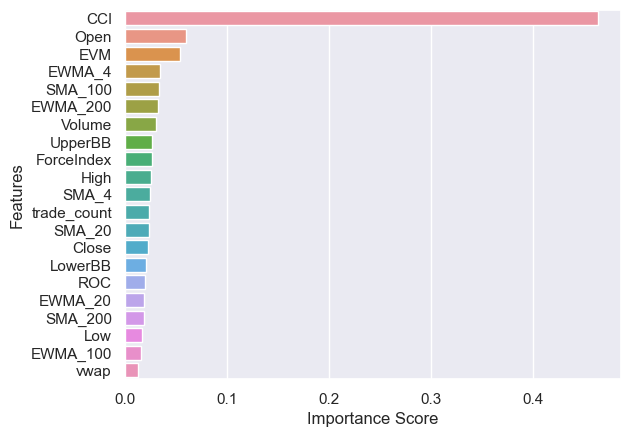

In [272]:
sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
plt.show()